- используемый датасет: Hearts Desease (https://archive.ics.uci.edu/dataset/45/heart+disease)

#Autoencoder

##Declare required dependencies

In [ ]:
pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from ucimlrepo import fetch_ucirepo

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ['0', '1']

## Data ingestion

In [ ]:
heart_disease = fetch_ucirepo(id=45)

dx = heart_disease.data.features
dy = heart_disease.data.targets

df = pd.concat([dx, dy], axis=1)

- cp - тип боли в груди
 -- Значение 1: типичная стенокардия
 -- Значение 2: атипичная стенокардия
 -- Значение 3: боль, не связанная с ангиной
 -- Значение 4: бессимптомная
- trestbps - артериальное давление в состоянии покоя при поступлении в больницу
- chol - холестерин
- fbs - уровень сахара в крови
- restecg - Возможные значения: 0 — нормальный результат, 1 — наличие аномалий ST-T-волны, 2 — вероятная или определённая гипертрофия левого желудочка по критериям Эстеса
- thalach - максимальная частота сердечных сокращений
- exang - стенокардия, вызванная физической нагрузкой
- oldpeak - Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом

## Data exploration

In [ ]:
display(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [ ]:
df.isnull().values.any()  #есть ли пропуски?

True

In [ ]:
df = df.dropna() #удалили строки с пропусками

## Class distribution

In [ ]:
df['num'] = df['num'].replace({2: 1, 3: 1, 4: 1}) #поменял значения: теперь целевая показывает не уровень, а наличие вероятности заболевания

In [ ]:
df['num'].value_counts()

,count
num,
0,164
1,139


In [ ]:
from imblearn.over_sampling import SMOTE
dx = df.drop('num', axis=1)
dy = df['num']
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(dx, dy)
df = pd.concat([X, y], axis=1)
df = pd.concat([df] * 100, ignore_index=True)

In [ ]:
df['num'].value_counts()

,count
num,
0,160000
1,160000


<ipython-input-21-5cb2f6f39dba>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['num'], sort = True)


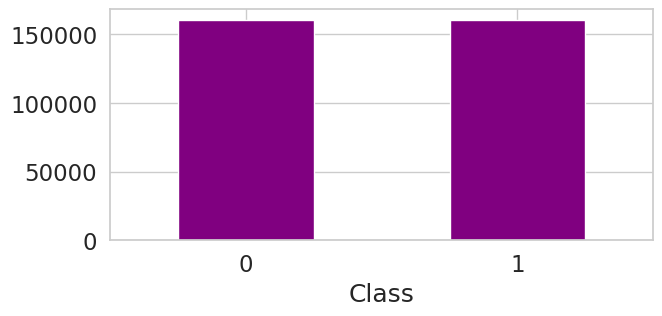

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))

count_classes = pd.value_counts(df['num'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color='purple', ax = ax)
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.show()

In [ ]:
heartDF = df[df.num == 1]   #есть вероятность заболевания
normalDF = df[df.num == 0]  #нет вероятности

In [ ]:
heartDF.chol.mean()

252.73125

In [ ]:
normalDF.chol.mean()

243.49375

In [ ]:
heartDF.thalach.describe()

,thalach
count,160000.000000
mean,138.912500
std,22.816838
min,71.000000
25%,124.000000
50%,142.000000
75%,157.000000
max,195.000000


In [ ]:
normalDF.thalach.describe()

,thalach
count,160000.00000
mean,158.58125
std,18.98376
min,96.00000
25%,149.00000
50%,161.00000
75%,172.00000
max,202.00000


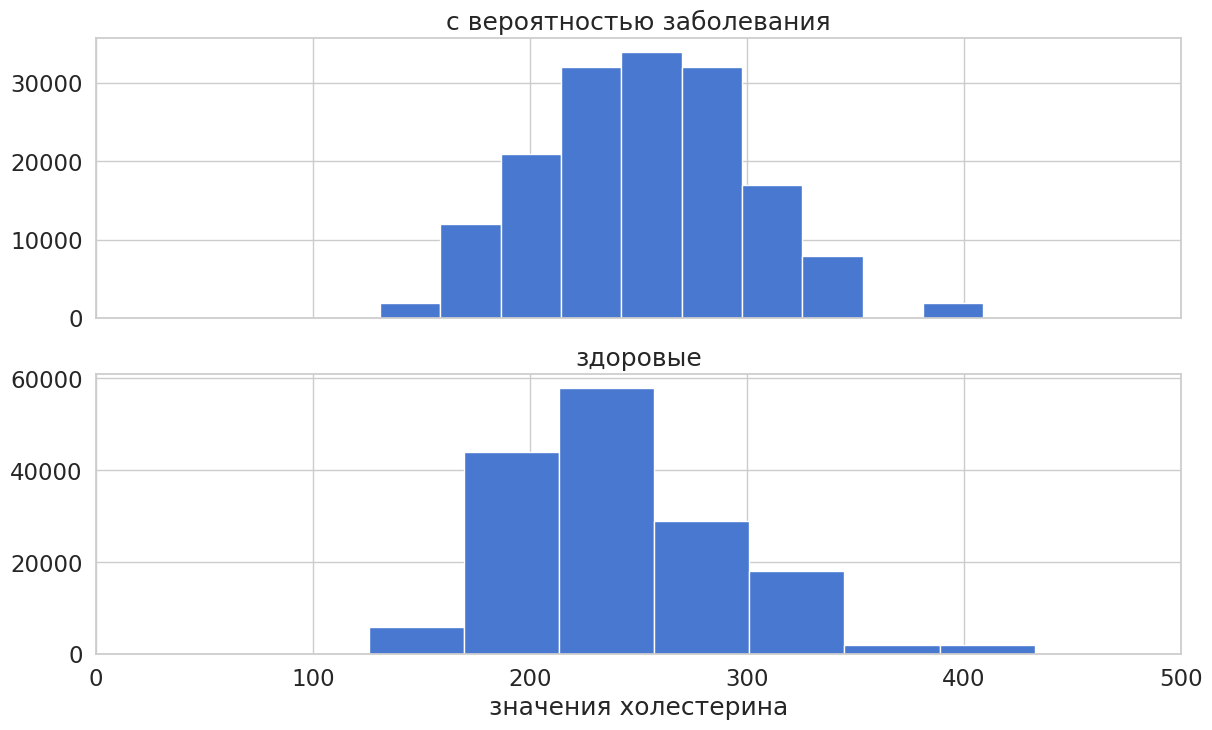

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.hist(heartDF.chol)
ax1.set_title('с вероятностью заболевания')

ax2.hist(normalDF.chol)
ax2.set_title('здоровые')

plt.xlabel('значения холестерина')
plt.xlim((0, 500))
plt.show();

Обе группы имеют схожие пики в диапазоне 200-300, что указывает на то, что уровень холестерина в этом диапазоне является наиболее распространенным как среди здоровых пациентов, так и среди тех, кто имеет вероятность заболевания.
Здоровые пациенты демонстрируют более широкий диапазон значений холестерина, включая более высокие значения, что может указывать на то, что уровень холестерина сам по себе не является единственным фактором, определяющим риск сердечно-сосудистых заболеваний

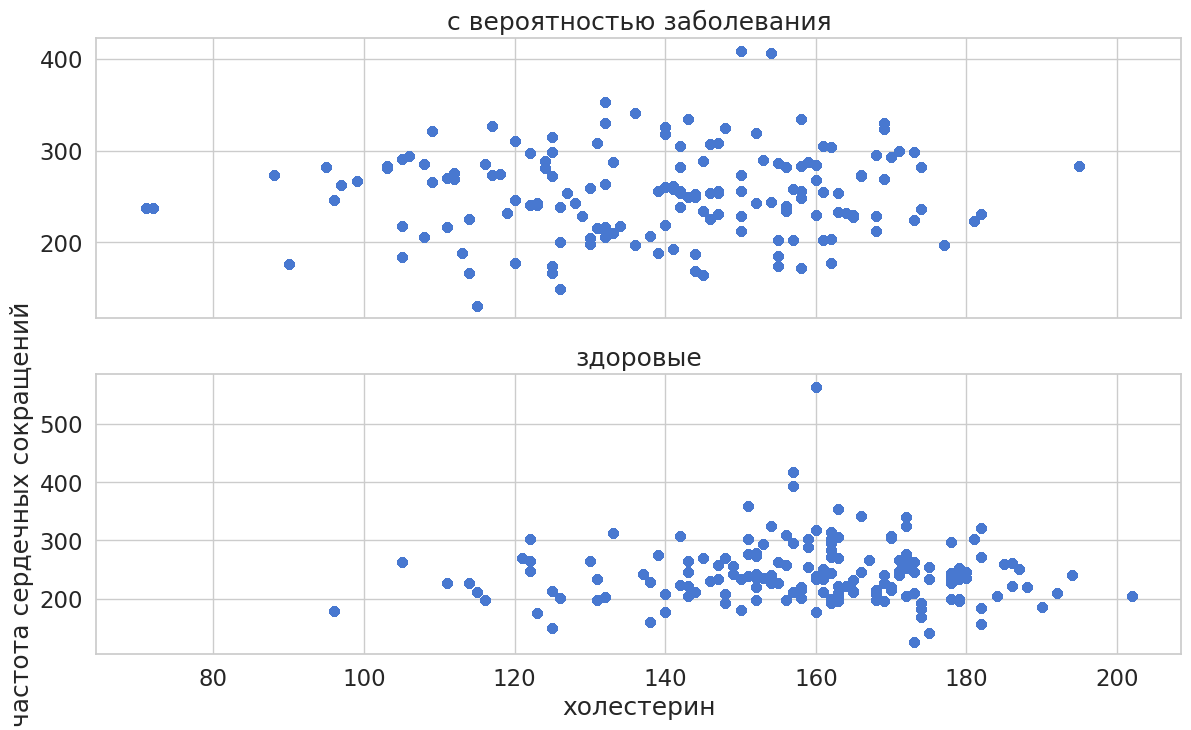

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.scatter(heartDF.thalach, heartDF.chol)
ax1.set_title('с вероятностью заболевания')

ax2.scatter(normalDF.thalach, normalDF.chol)
ax2.set_title('здоровые')

plt.xlabel('холестерин')
plt.ylabel('частота сердечных сокращений')
plt.show()

## Preprocessing

стандартизация данных

In [ ]:
#df['chol'] = StandardScaler().fit_transform(df['chol'].values.reshape(-1, 1))

In [ ]:
cols = df.columns
cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal']

In [ ]:
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.944214,0.703795,-2.273366,0.754607,-0.296190,2.472066,1.003382,0.054066,-0.679108,1.097474,2.307547,-0.754459,0.629684,0
1,1.396025,0.703795,0.880436,1.614762,0.742559,-0.404520,1.003382,-1.758017,1.472521,0.393709,0.670263,2.483485,-0.937761,1
2,1.396025,0.703795,0.880436,-0.678985,-0.374587,-0.404520,1.003382,-0.851976,1.472521,1.361386,0.670263,1.404170,1.152166,1
3,-1.992557,0.703795,-0.170831,-0.105548,0.036993,-0.404520,-1.028784,1.650425,-0.679108,2.153123,2.307547,-0.754459,-0.937761,0
4,-1.540746,-1.420869,-1.222098,-0.105548,-0.864563,-0.404520,1.003382,1.003252,-0.679108,0.305738,-0.967021,-0.754459,-0.937761,0


### Разделите набор данных на наборы обучающих и тестовых данных.

 набор данных как обучение = 80% и тест = 20%
 в обучающем наборе данных будут только здоровые, а в тестовом наборе данных будут все

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train[X_train['num'] == 0]
X_train = X_train.drop(['num'], axis=1)

y_test = X_test['num']
X_test = X_test.drop(['num'], axis=1)

X_train = X_train.values

X_test = X_test.values
y_test = y_test.values
print(y_test.size)

64000


## Model

автоэнкодер, состоящий из 4 полносвязных слоев с 13, 8, 4, 13 нейронами.
Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер

последний слой имеет 13 узлов, соответствующих 13 функциям в элементе входных данных.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #кодирующий слой
        self.encoder = nn.Sequential(
            nn.Linear(13, 8),
            nn.Tanh(),
            nn.Linear(8, 4),
            nn.LeakyReLU(),
            )

        #декодирующий
        self.decoder = nn.Sequential(
           nn.Linear(4, 8),
           nn.Tanh(),
           nn.Linear(8, 13),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double()

In [ ]:
num_epochs = 150   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей/векторов, которые передаются в наш алгоритм обучения.

Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик. По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.

**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [ ]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [ ]:
#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [ ]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

- Проходит определенное количество эпох.
- На каждой эпохе проходит через весь обучающий набор данных с расчетом потерь.
- Производится обновление параметров модели с использованием методов обратного распространения.
- В конце сохраняются веса обученной модели для дальнейшего использования.

In [ ]:
if np.any(np.isnan(df)) or np.any(np.isinf(df)):
    print("Данные содержат nan или inf значения.")

In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/150], loss:0.7220
epoch [2/150], loss:0.6520
epoch [3/150], loss:0.6372
epoch [4/150], loss:0.6300
epoch [5/150], loss:0.6215
epoch [6/150], loss:0.6135
epoch [7/150], loss:0.6095
epoch [8/150], loss:0.6055
epoch [9/150], loss:0.6008
epoch [10/150], loss:0.5981
epoch [11/150], loss:0.5956
epoch [12/150], loss:0.5934
epoch [13/150], loss:0.5914
epoch [14/150], loss:0.5909
epoch [15/150], loss:0.5896
epoch [16/150], loss:0.5882
epoch [17/150], loss:0.5870
epoch [18/150], loss:0.5860
epoch [19/150], loss:0.5850
epoch [20/150], loss:0.5841
epoch [21/150], loss:0.5831
epoch [22/150], loss:0.5824
epoch [23/150], loss:0.5819
epoch [24/150], loss:0.5814
epoch [25/150], loss:0.5804
epoch [26/150], loss:0.5794
epoch [27/150], loss:0.5791
epoch [28/150], loss:0.5776
epoch [29/150], loss:0.5759
epoch [30/150], loss:0.5755
epoch [31/150], loss:0.5753
epoch [32/150], loss:0.5749
epoch [33/150], loss:0.5746
epoch [34/150], loss:0.5744
epoch [35/150], loss:0.5744
epoch [36/150], loss:0.5742
e

Конечное значение ошибки (0.5648) указывает на то, что модель достаточно хорошо реконструирует входные данные.

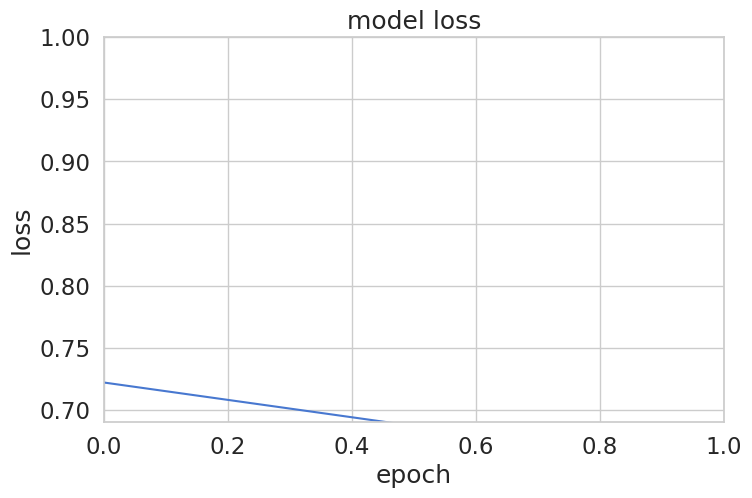

In [ ]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, 1, 0.69, 1])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

Быстрое снижение ошибки в начале обучения и её стабилизация в последующих эпохах указывают на то, что модель хорошо сходится.

## Оценка модели

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data

        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()

        pred_losses['pred_loss'].append(loss)

reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['num'] = y_test

In [ ]:
reconstructionErrorDF.describe()

,pred_loss,num
count,64000.000000,64000.000000
mean,0.818641,0.499375
std,0.530816,0.500004
min,0.229556,0.000000
25%,0.446838,0.000000
50%,0.680595,0.000000
75%,0.949078,1.000000
max,3.272445,1.000000


Модель автоэнкодера показывает хорошие результаты в реконструкции входных данных, что подтверждается средним значением ошибки реконструкции.
Целевая переменная имеет примерно равномерное распределение классов, что указывает на сбалансированность данных.

# Reconstruction Errors without Fraud

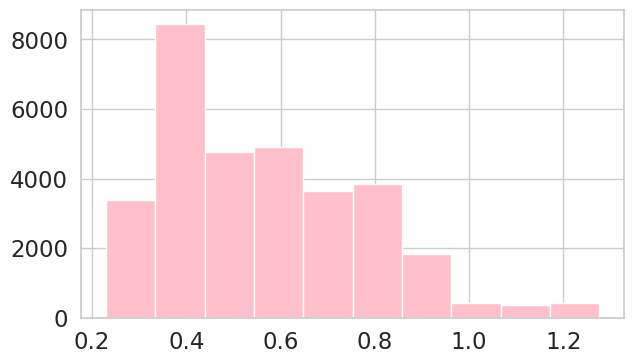

In [ ]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['num']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10, color = 'pink')

Ошибки реконструкции больше 1.0 встречаются редко, что может указывать на наличие аномалий или выбросов в данных.
График подтверждает, что модель автоэнкодера хорошо справляется с реконструкцией данных для здоровых пациентов.

# Reconstruction Errors with Fraud

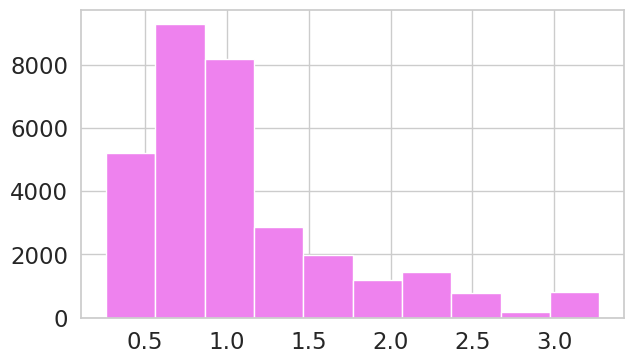

In [ ]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['num']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10, color = 'violet')

График подтверждает, что модель автоэнкодера имеет более высокие ошибки реконструкции для пациентов с вероятностью заболевания, что может быть использовано для обнаружения аномалий.

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

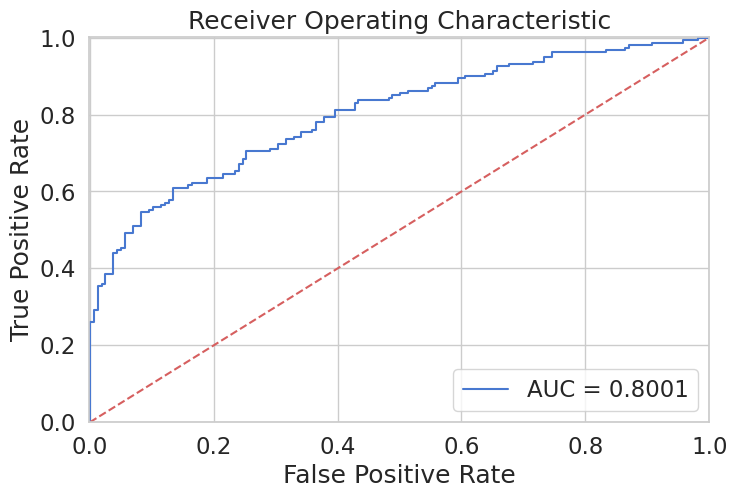

In [ ]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.num, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

ROC-кривая и значение AUC подтверждают, что модель автоэнкодера эффективна в обнаружении вероятности заболевания сердечно-сосудистыми заболеваниями

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

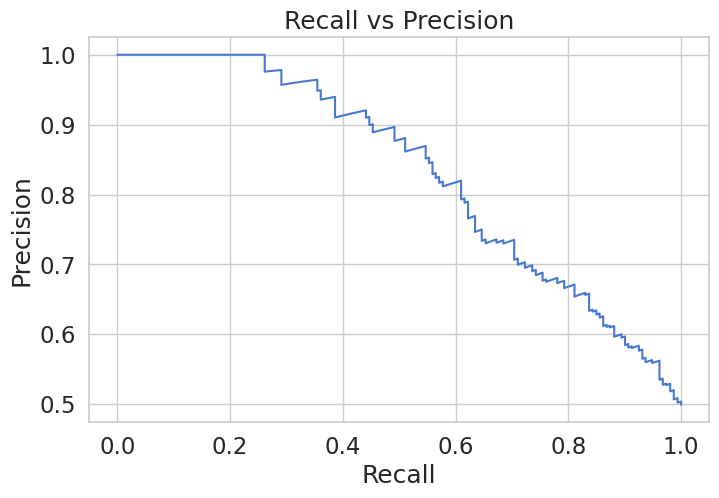

In [ ]:
plt.figure(figsize=(8, 5))
precision, recall, th = precision_recall_curve(reconstructionErrorDF.num, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

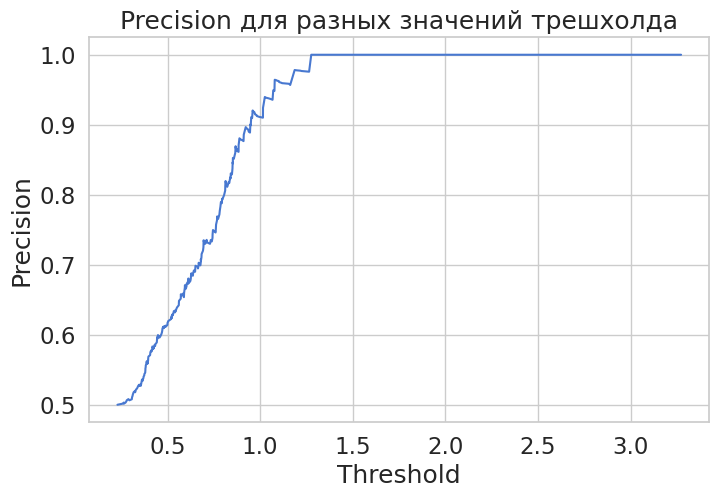

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


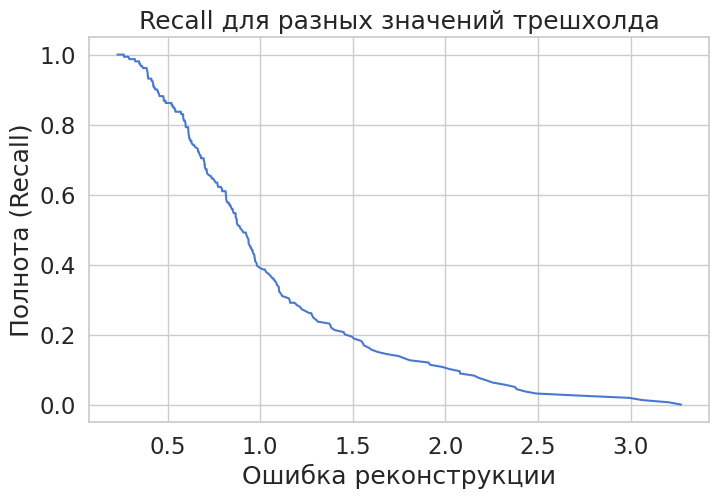

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Для предсказания вероятности заболевания у человека, рассчитаем ошибку реконструкции на основе данных.

Если ошибка превышает предопределенный порог, мы помечаем ее как есть вероятность заболевания (т.к. модель должна иметь низкую оценку при отсутствии заболевания)

In [ ]:
threshold = 0.5

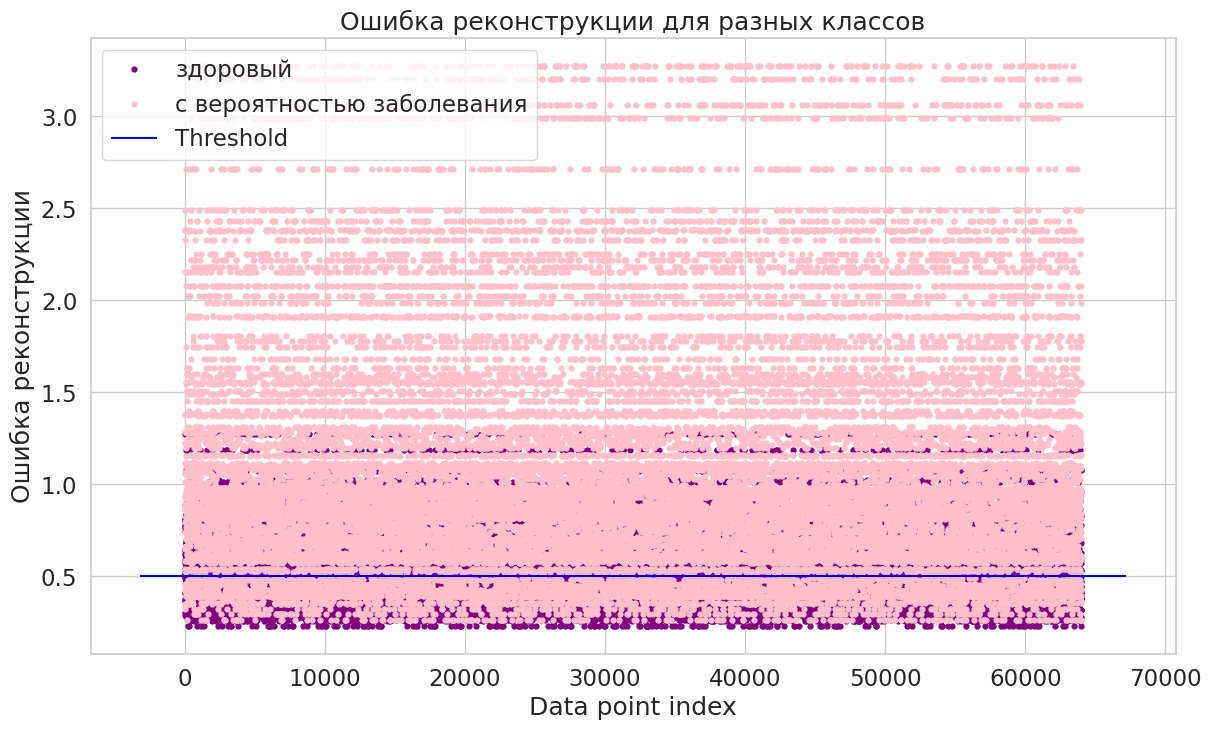

In [ ]:
groups = reconstructionErrorDF.groupby('num')
fig, ax = plt.subplots()

colors = {1: 'pink', 0: 'purple'}

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "с вероятностью заболевания" if name == 1 else "здоровый", color=colors[name])
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="blue", zorder=100, label='Threshold')
ax.legend()

plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

График подтверждает, что модель автоэнкодера эффективна в обнаружении аномалий, связанных с вероятностью заболевания сердечно-сосудистыми заболеваниями.
Установленный порог позволяет разделять данные на нормальные и аномальные, что может быть использовано для дальнейшего анализа и предсказаний.

<ipython-input-60-8f451ae319b2>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Pastel1'));


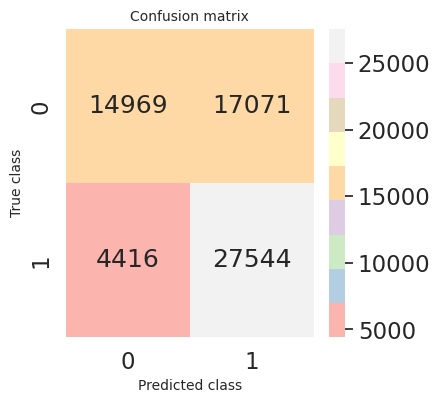

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.num, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Pastel1'));
plt.title("Confusion matrix", size = 10)
plt.ylabel('True class', size = 10)
plt.xlabel('Predicted class', size = 10)
plt.show()

Полнота модели высокая, так как большинство пациентов с вероятностью заболевания правильно классифицированы.
Точность модели ниже, так как значительное количество здоровых пациентов неправильно классифицировано.
Матрица ошибок подтверждает, что модель автоэнкодера эффективна в обнаружении пациентов с вероятностью заболевания сердечно-сосудистыми заболеваниями.